In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from tqdm import tqdm
#nltk.download('stopwords')
#nltk.download('punkt')

In [2]:
# The tokenizer of nltk was too slow for that case.
# So, we will use python regular expressions to 
# increase speed

def tokenize_and_count(text):
    """
    This function will tokenize a text using regular
    expressions and counts the number of times each
    token is present in the text
    """
    # Tokenize the text
    p = re.compile("[a-z]+") # Using a regular expression here
    tokens = p.findall(text.lower())
    tokens_counts = Counter(tokens)
    final_dict = {k: v for k, v in sorted(tokens_counts.items(), key=lambda item: item[1], reverse=True)}
    return final_dict

def fair_compose(tokens_positive, tokens_negative, n=100):
    """
    Given the most common words on each class, this function
    will compose a vocabulary with the words that are common
    to both classes while keeping the most popular words for
    each class. 
    """
    vocabulary = []
    i = 0
    j = 0
    while len(set(vocabulary)) < n:
        while True:
            w = list(tokens_positive.keys())[i]
            i +=1
            if w not in stopwords.words('english'):
                vocabulary.append(w)
                break
        while True:
            w = list(tokens_negative.keys())[j]
            j +=1
            if w not in stopwords.words('english'):
                vocabulary.append(w)
                break
    return list(set(vocabulary))

def compute_vocabulary(text_positive, text_negative, n=100):
    """
    This function will create a vocabulary with the n most frequent words
    that are present in the text_positive and text_negative at the same
    time.  
    The function will also remove the stopwords and compute the frequency
    for each word in the positive texts and the negative texts.
    Returns two dictionaries.
    """
    tokens_positive = tokenize_and_count(text_positive)
    del(tokens_positive['br'])
    tokens_negative = tokenize_and_count(text_negative)
    del(tokens_negative['br'])
    vocabulary = fair_compose(tokens_positive, tokens_negative, n)
    vocab_freq_positive = {}
    vocab_freq_negative = {}
    word_counts_positive = 0
    word_counts_negative = 0
    for w in vocabulary:
        vocab_freq_positive[w] = tokens_positive[w]
        word_counts_positive += tokens_positive[w]
        vocab_freq_negative[w] = tokens_negative[w]
        word_counts_negative += tokens_negative[w]
    # Normalize
    for w in vocab_freq_positive.keys():
        vocab_freq_positive[w] = vocab_freq_positive[w] / word_counts_positive
        vocab_freq_negative[w] = vocab_freq_negative[w] / word_counts_negative
    return vocab_freq_positive, vocab_freq_negative


In [3]:
data = pd.read_csv("./IMDB_Dataset.csv")

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.shape

(50000, 2)

In [6]:
# Our training set will be formed by 20k positive and 20k negative reviews
nb_words_vocabulary = 2000
data_positive = data[data['sentiment']=='positive']
data_negative = data[data['sentiment']=='negative']
# Training set
text_positive_train = " ".join(list(data_positive['review'][:20000]))
text_negative_train = " ".join(list(data_negative["review"][:20000]))
# Test set
test_dataset = pd.concat([data_positive.iloc[20000:], data_negative.iloc[20000:]], 
                         ignore_index=True, sort=False)

freq_positive, freq_negative = compute_vocabulary(text_positive_train, text_negative_train, nb_words_vocabulary)

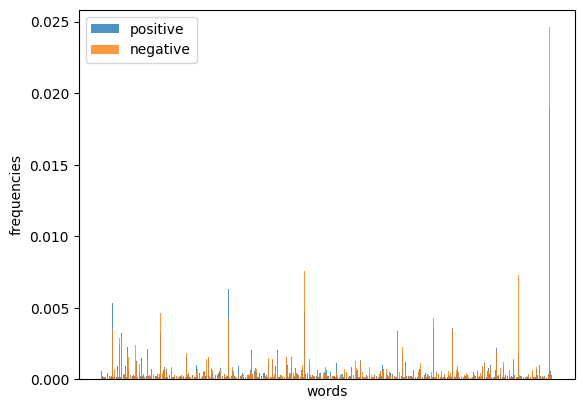

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(list(freq_positive.keys()), list(freq_positive.values()), alpha=0.8, label="positive")
ax.bar(list(freq_negative.keys()), list(freq_negative.values()), alpha=0.8, label="negative")
ax.set_xlabel("words")
ax.set_ylabel("frequencies")
plt.xticks([])
plt.legend(loc='best')
plt.show()

In [8]:
test_dataset.head()

,review,sentiment
0,This movie is stuffed full of stock Horror mov...,positive
1,"When the Romulans come, they will not be beari...",positive
2,This was a movie that I had heard about all my...,positive
3,Let me begin by saying that there is no bigger...,positive
4,"I haven't seen BSG, I tried to watch it once i...",positive


## Let's clasify a review


In [9]:
review = test_dataset.iloc[50]
print(review["review"])
print(review["sentiment"])

I agree with "johnlewis", who said that there is a lot going on between the lines in this film. While I do think the pacing of this film could be improved, I do think that the complexity of the relationships between the characters is fascinating.<br /><br />Examples : <br /><br />Pierre is going to marry his cousin, even though his love for her seems very cousin-y ? <br /><br />Pierre and his stepmother have a rather...curious relationship.<br /><br />Pierre, Lucie, and Thibault seem to have a triangular relationship, and the actual points to the triangle are not quite certain...<br /><br />Lucie's brother is a bit of a eunuch, or is he ? <br /><br />And Isabelle, who is she really ?? <br /><br />Overall, I think it was worth my time. An interesting film, and one that makes me want to read Melville.
positive


In [10]:
# tokenize the text
vocabulary = list(freq_positive.keys())
# tokenize the review
p = re.compile("[a-z]+")
words = p.findall(review["review"].lower())
features = list(set(words) & set(vocabulary))
print(features)



['relationship', 'actual', 'fascinating', 'characters', 'interesting', 'lines', 'one', 'makes', 'read', 'going', 'agree', 'love', 'seem', 'though', 'said', 'even', 'quite', 'time', 'overall', 'could', 'rather', 'brother', 'pacing', 'lot', 'seems', 'worth', 'relationships', 'think', 'film', 'really', 'certain', 'bit', 'want', 'points']


In [11]:
P_Ck_positive = 0
P_Ck_negative = 0
for w in features:
    #print(w)
    P_Ck_positive += np.log(freq_positive[w])
    P_Ck_negative += np.log(freq_negative[w])
if P_Ck_positive > P_Ck_negative:
    print (True, "positive", review["sentiment"])
else:
    print (True, "negative", review["sentiment"])


True positive positive


## Let's compute the confusion matrix

(see [here](https://en.wikipedia.org/wiki/Confusion_matrix) for details)

In [12]:
# Create the confusion Matrix
# see here https://en.wikipedia.org/wiki/Confusion_matrix

def classify_NaiveBayes(line, frequencies_positive_dict, frequencies_negative_dict):
    """
    Give the classification using Naive Bayes
    """
    vocabulary = list(frequencies_positive_dict.keys())
    # tokenize the review
    p = re.compile("[a-z]+")
    words = p.findall(line["review"].lower())
    features = list(set(words) & set(vocabulary))
    if len(features) == 0: # The review cannot be classified
        return (False, "", "")
    P_Ck_positive = 0
    P_Ck_negative = 0
    for w in features:
        #print(w)
        P_Ck_positive += np.log(frequencies_positive_dict[w])
        P_Ck_negative += np.log(frequencies_negative_dict[w])
    if P_Ck_positive > P_Ck_negative:
        return (True, "positive", line["sentiment"])
    else:
        return (True, "negative", line["sentiment"])


In [13]:
confusion_matrix = np.array([[0, 0], [0, 0]])

In [14]:
for ix, line in tqdm(test_dataset.iterrows()):
    classif_OK, predicted, real = classify_NaiveBayes(line, freq_positive, freq_negative)
    if classif_OK:         
        if predicted == real:
            if real == "positive":
                confusion_matrix[0, 0] +=1
            else:
                confusion_matrix[1, 1] +=1
        else:
            if real == "positive":
                confusion_matrix[0, 1] +=1
            else:
                confusion_matrix[1, 0] +=1

# Normalize the confusion matrix


10000it [00:04, 2371.07it/s]


In [15]:
positive = confusion_matrix[0, ] / confusion_matrix.sum(axis=1)[0]
negative = confusion_matrix[1, ] / confusion_matrix.sum(axis=1)[1]
normalized_confusion_matrix = np.array([positive, negative])
print(normalized_confusion_matrix)

[[0.8536 0.1464]
 [0.1474 0.8526]]
